## **Hybrid recommender** with MovieLens (small dataset).
**combine collaborative filtering (CF) + content-based (CBF)** into one recommendation score.

---

## 🔹 Hybrid Approach

1. **Collaborative Filtering (CF)**

   * Compute **item–item similarity** using ratings (user–item matrix).

2. **Content-Based Filtering (CBF)**

   * Compute **item–item similarity** using metadata (genres).

3. **Hybrid Score**

   * Blend the two similarities with a weight factor `α`:

     $$
     \text{HybridSim} = \alpha \cdot \text{CF\_sim} + (1-\alpha) \cdot \text{CBF\_sim}
     $$


## 🔹 How it works

* **Content similarity**: based on genres.
* **Collaborative similarity**: based on rating patterns.
* **Hybrid**: blends both (you can tune `α` → closer to `1.0` = more CF, closer to `0.0` = more content-based).

---

✅ With this, you can:

* Show **pure content-based** (`α=0`),
* Show **pure collaborative** (`α=1`),
* Show **hybrid** (`0 < α < 1`).

---


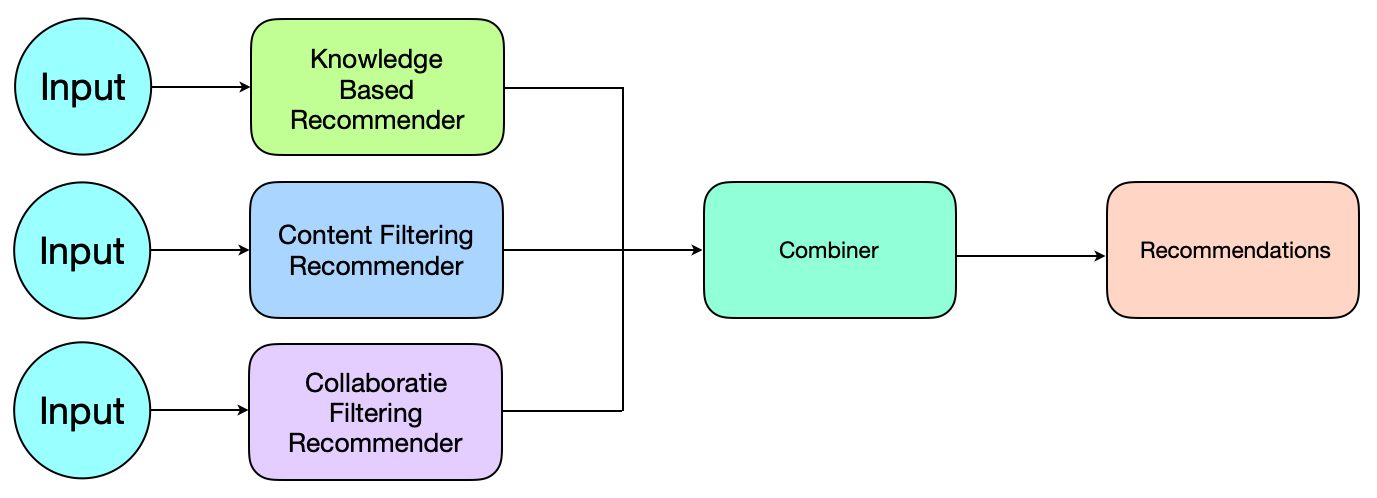
image source:https://www.oreilly.com/library/view/r-machine-learning/9781789807943/930bc5ce-173e-43b9-94e1-dd991e61497f.xhtml

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Load MovieLens small dataset 
movies = pd.read_csv("movies.csv")   # movieId, title, genres
ratings = pd.read_csv("ratings.csv") # userId, movieId, rating, timestamp
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [7]:
# Content-based similarity (genres) 
genres_split = movies['genres'].str.get_dummies(sep='|')
content_sim = cosine_similarity(genres_split)
content_sim_df = pd.DataFrame(content_sim, 
                              index=movies['movieId'], 
                              columns=movies['movieId'])
print(content_sim_df)

movieId    1         2         3         4         5         6         7       \
movieId                                                                         
1        1.000000  0.774597  0.316228  0.258199  0.447214  0.000000  0.316228   
2        0.774597  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3        0.316228  0.000000  1.000000  0.816497  0.707107  0.000000  1.000000   
4        0.258199  0.000000  0.816497  1.000000  0.577350  0.000000  0.816497   
5        0.447214  0.000000  0.707107  0.577350  1.000000  0.000000  0.707107   
...           ...       ...       ...       ...       ...       ...       ...   
193581   0.670820  0.288675  0.353553  0.288675  0.500000  0.288675  0.353553   
193583   0.774597  0.333333  0.408248  0.333333  0.577350  0.000000  0.408248   
193585   0.000000  0.000000  0.000000  0.577350  0.000000  0.000000  0.000000   
193587   0.316228  0.000000  0.000000  0.000000  0.000000  0.408248  0.000000   
193609   0.447214  0.000000 

In [9]:
# Collaborative similarity (item–item from ratings)
# Create user-item matrix
user_item = ratings.pivot_table(index='userId', columns='movieId', \
                                        values='rating').fillna(0)

# Cosine similarity between items (transpose so items × users)
collab_sim = cosine_similarity(user_item.T)
collab_sim_df = pd.DataFrame(collab_sim, 
                             index=user_item.columns, 
                             columns=user_item.columns)
collab_sim_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Hybrid similarity 
alpha = 0.5  # weight between CF and CBF
common_movies = list(set(content_sim_df.index) & set(collab_sim_df.index))

hybrid_sim = alpha * collab_sim_df.loc[common_movies, common_movies] + \
             (1 - alpha) * content_sim_df.loc[common_movies, common_movies]

hybrid_sim_df = pd.DataFrame(hybrid_sim, index=common_movies, \
                             columns=common_movies)
hybrid_sim_df

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,32743,98279,65514,98296
1,1.000000,0.592579,0.306572,0.146886,0.377988,0.188158,0.296859,0.382042,0.116293,0.326886,...,0.053143,0.448156,0.191176,0.029775,0.021268,0.283720,0.042535,0.267375,0.052680,0.042535
2,0.592579,1.000000,0.141219,0.053207,0.143897,0.148505,0.114288,0.494497,0.022418,0.375513,...,0.042037,0.441179,0.027415,0.000000,0.000000,0.200312,0.067292,0.020773,0.081758,0.040375
3,0.306572,0.141219,1.000000,0.454451,0.562454,0.142128,0.701416,0.156717,0.152420,0.121477,...,0.000000,0.011316,0.263031,0.000000,0.000000,0.030385,0.000000,0.384820,0.000000,0.060771
4,0.146886,0.053207,0.454451,1.000000,0.382863,0.044843,0.545766,0.079011,0.000000,0.047799,...,0.000000,0.000000,0.204124,0.000000,0.166667,0.166667,0.166667,0.288675,0.166667,0.166667
5,0.377988,0.143897,0.562454,0.382863,1.000000,0.149484,0.590554,0.141762,0.167529,0.109030,...,0.000000,0.021198,0.409792,0.000000,0.000000,0.000000,0.000000,0.534453,0.000000,0.066965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163809,0.283720,0.200312,0.030385,0.166667,0.000000,0.055295,0.051095,0.204124,0.057438,0.208983,...,0.000000,0.258199,0.000000,0.000000,0.166667,1.000000,0.166667,0.000000,0.166667,0.166667
32743,0.042535,0.067292,0.000000,0.166667,0.000000,0.228105,0.000000,0.000000,0.000000,0.227119,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,1.000000,0.000000,0.362632,0.333333
98279,0.267375,0.020773,0.384820,0.288675,0.534453,0.000000,0.353553,0.000000,0.000000,0.024882,...,0.000000,0.047902,0.523629,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.257248
65514,0.052680,0.081758,0.000000,0.166667,0.000000,0.244203,0.000000,0.000000,0.288675,0.222582,...,0.506183,0.040870,0.086140,0.000000,0.166667,0.166667,0.362632,0.000000,1.000000,0.166667


In [23]:
# Recommend similar movies 
def hybrid_recommend(movie_title, top_n=5):
    # find movieId
    row = movies[movies['title'] == movie_title]
    if row.empty:
        return f"Movie '{movie_title}' not found."
    
    movie_id = row['movieId'].values[0]
    
    if movie_id not in hybrid_sim_df.index:
        return f"No hybrid similarity available for '{movie_title}'."
    
    # get similarity scores
    sim_scores = hybrid_sim_df[movie_id].sort_values(ascending=False)
    sim_scores = sim_scores.drop(movie_id)  # exclude itself
    
    # map back to titles
    rec_ids = sim_scores.index[:top_n]
    recommendations = movies[movies['movieId'].isin(rec_ids)][['movieId', 'title']]
    
    return recommendations

In [25]:
# Example usage
print("\nHybrid recommendations for 'Toy Story (1995)':")
print(hybrid_recommend("Toy Story (1995)", top_n=5))


Hybrid recommendations for 'Toy Story (1995)':
      movieId                  title
1757     2355   Bug's Life, A (1998)
2355     3114     Toy Story 2 (1999)
3194     4306           Shrek (2001)
3568     4886  Monsters, Inc. (2001)
4360     6377    Finding Nemo (2003)
